# Introduction

ARIMA models are, in theory, the most general class of models for forecasting a time series, which can be made to be “stationary” by differencing (if necessary), perhaps in conjunction with nonlinear transformations such as logging or deflating (if necessary). A random variable that is a time series is stationary if its statistical properties are all constant over time. A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion, i.e., its short-term random time patterns always look the same in a statistical sense. The latter condition means that its autocorrelations (correlations with its prior deviations from the mean) remain constant over time, or equivalently, that its power spectrum remains constant over time. A random variable of this form can be viewed (as usual) as a combination of signal and noise, and the signal (if one is apparent) could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component. An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts.

# The Data

The data we will use is annual sunspot data from 1700 – 2008 recording the number of sunspots per year. The file sunspots.csv and can be downloaded from the line below.

# Import Packages

In addition to Statsmodels, we will need to import additional packages, including Numpy, Scipy, Pandas, and Matplotlib.

Also, from Statsmodels we will need to import qqplot.

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.graphics.api import qqplot

In [4]:
dta= pd.read_csv(r"D:\Time_Series\Time_Series_Analysis\data\sunspots.csv")
dta.head(10)

,YEAR,SUNACTIVITY
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0
5,1705,58.0
6,1706,29.0
7,1707,20.0
8,1708,10.0
9,1709,8.0


In [6]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [7]:
dta

,YEAR,SUNACTIVITY
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0
...,...,...
304,2004,40.4
305,2005,29.8
306,2006,15.2
307,2007,7.5


# Preparing the Data

Next we need to do a little dataset preparation. Here, an annual date series must be date-times at the end of the year.

In [8]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

In [9]:
dta.head(10)

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
1705-12-31,58.0
1706-12-31,29.0
1707-12-31,20.0
1708-12-31,10.0
1709-12-31,8.0


# Examine the Data

Now we take a look at the data.

<Axes: >

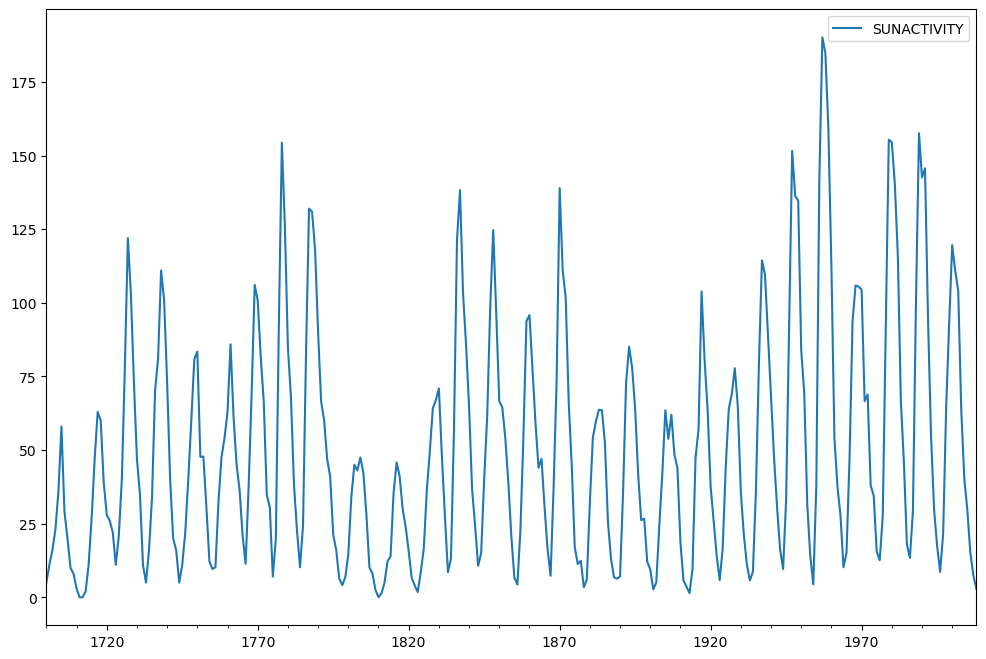

In [10]:
# show plots in the notebook
%matplotlib inline
dta.plot(figsize=(12,8))

# Auto-correlations

Before we decide which model to use, we need to look at auto-correlations.

#### Autocorrelation correlogram. 
Seasonal patterns of time series can be examined via correlograms, which display graphically and numerically the autocorrelation function (ACF). Auto-correlation in pandas plotting and statsmodels graphics standardize the data before computing the auto-correlation. These libraries subtract the mean and divide by the standard deviation of the data.

When using standardization, they make an assumption that your data has been generated with a Gaussian law (with a certain mean and standard deviation). This may not be the case in reality.

Correlation is sensitive. Both (matplotlib and pandas plotting) of these functions have their drawbacks. The figure generated by the following code using matplotlib will be identical to figure generated by pandas plotting or statsmodels graphics.

#### Partial autocorrelations. 
Another useful method to examine serial dependencies is to examine the partial autocorrelation function (PACF) – an extension of autocorrelation, where the dependence on the intermediate elements (those within the lag) is removed.

Once we determine the nature of the auto-correlations we use the following rules of thumb.

   * Rule 1: If the ACF shows exponential decay, the PACF has a spike at lag 1, and no correlation for other lags, then use one autoregressive (p)parameter
   * Rule 2: If the ACF shows a sine-wave shape pattern or a set of exponential decays, the PACF has spikes at lags 1 and 2, and no correlation for other lags, the use two autoregressive (p) parameters
   * Rule 3: If the ACF has a spike at lag 1, no correlation for other lags, and the PACF damps out exponentially, then use one moving average (q) parameter.
   * Rule 4: If the ACF has spikes at lags 1 and 2, no correlation for other lags, and the PACF has a sine-wave shape pattern or a set of exponential decays, then use two moving average (q) parameter.
   * Rule 5: If the ACF shows exponential decay starting at lag 1, and the PACF shows exponential decay starting at lag 1, then use one autoregressive (p) and one moving average (q) parameter.
   
#### Removing serial dependency. 
Serial dependency for a particular lag can be removed by differencing the series. There are two major reasons for such transformations.

   * First, we can identify the hidden nature of seasonal dependencies in the series. Autocorrelations for consecutive lags are interdependent, so removing some of the autocorrelations will change other auto correlations, making other seasonalities more apparent.
   * Second, removing serial dependencies will make the series stationary, which is necessary for ARIMA and other techniques.


Another popular test for serial correlation is the Durbin-Watson statistic. The DW statistic will lie in the 0-4 range, with a value near two indicating no first-order serial correlation. Positive serial correlation is associated with DW values below 2 and negative serial correlation with DW values above 2.

In [11]:
sm.stats.durbin_watson(dta)

array([0.13952893])

The value of Durbin-Watson statistic is close to 2 if the errors are uncorrelated. In our example, it is 0.1395. That means that there is a strong evidence that the variable open has high autocorrelation.

c:\Users\navee\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


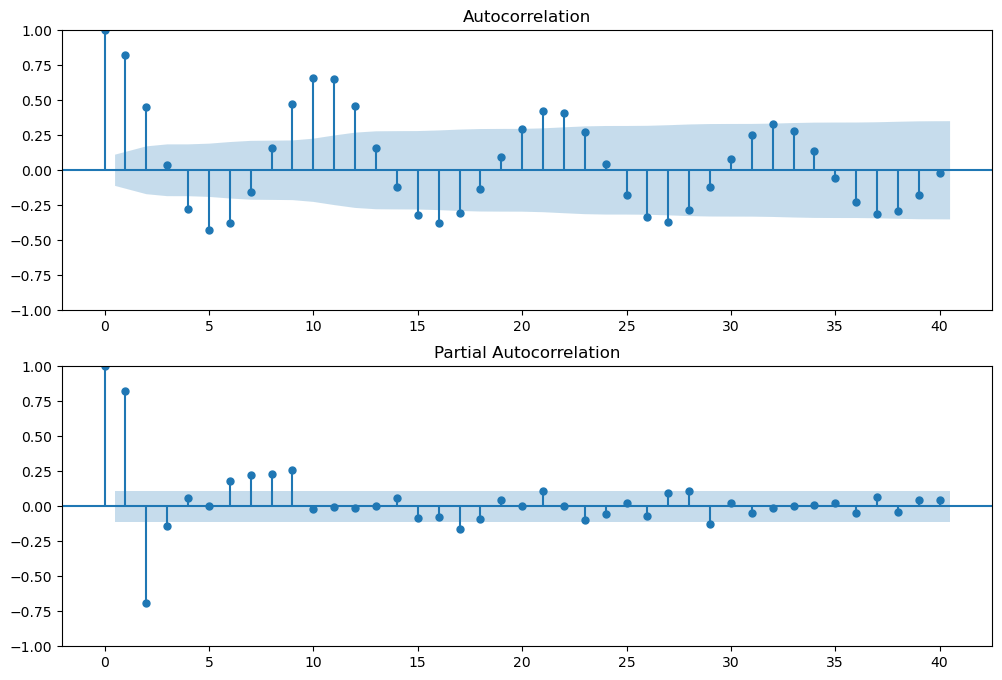

In [12]:
# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

The plots also indicate that autocorrelation is present. Another set of plots (shown below) are available using the autocorrelation_plot function from Pandas.

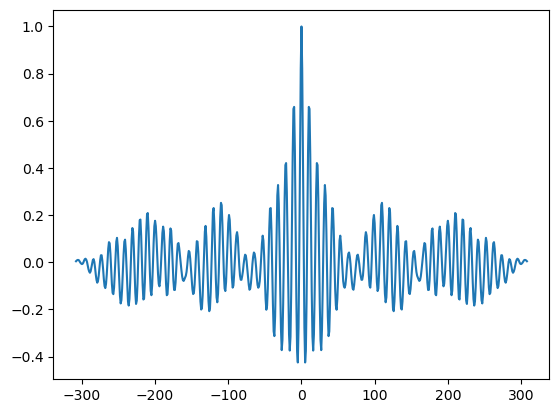

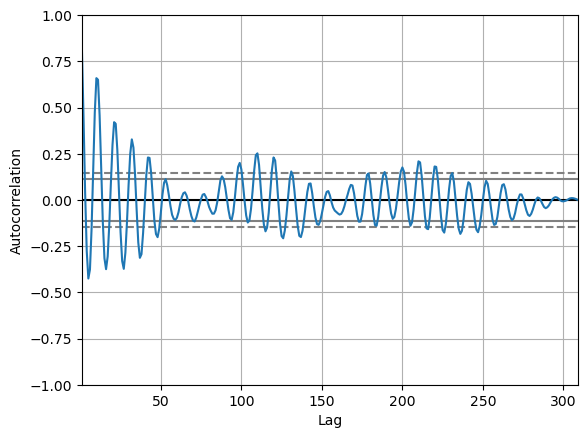

In [13]:
from pandas.plotting import autocorrelation_plot
# show plots in the notebook
%matplotlib inline
dta['SUNACTIVITY_2'] = dta['SUNACTIVITY']
dta['SUNACTIVITY_2'] = (dta['SUNACTIVITY_2'] - dta['SUNACTIVITY_2'].mean()) / (dta['SUNACTIVITY_2'].std())
plt.acorr(dta['SUNACTIVITY_2'],maxlags = len(dta['SUNACTIVITY_2']) -1, linestyle = "solid", usevlines = False, marker='')
plt.show()
autocorrelation_plot(dta['SUNACTIVITY'])
plt.show()

For mixed ARMA processes the Autocorrelation function is a mixture of exponentials and damped sine waves after (q-p) lags. The partial autocorrelation function is a mixture of exponentials and dampened sine waves after (p-q) lags.

# Times Series Modeling
We will only explore two methods here. An ARMA model is classified as ARMA(p,q), with no differenceing terms. ARMA models can be described by a series of equations. The equations are somewhat simpler if the time series is first reduced to zero-mean by subtracting the sample mean. Therefore, we will work with the mean-adjusted series

    yt = Yt – Y̅, t = 1, …N

where Yt is the original time series, Y̅ is its sample mean, and yt is the mean-adjusted series. One subset of ARMA models are the so-called autoregressive, or AR models. An AR model expresses a time series as a linear function of its past values. The order of the AR model tells how many lagged past values are included. The simplest AR model is the first-order autoregressive, or AR(1), model

    yt + a1 yt-1 = et

where yt is the mean-adjusted series in year t, yt-1 is the series in the previous year, at is the lag-1 autoregressive coefficient, and et is the noise. The noise also goes by various other names: the error, the random-shock, and the residual. The residuals et are assumed to be random in time (not autocorrelated), and normally distributed. Be rewriting the equation for the AR(1) model as

    yt = a1 yt-1 + et

We see that the AR(1) model has the form of a regression model in which yt is regressed on its previous value. In this form, at is analogous to the negative of the regression coefficient, and et to the regression residuals. The name autoregressive refers to the regression on self (auto).

A nonseasonal ARIMA model is classified as an ARIMA(p,d,q) model, where:

   * p is the number of autoregressive terms,
   * d is the number of nonseasonal differences needed for stationarity, and
   * q is the number of lagged forecast errors in the prediction equation.
   
The forecasting equation is constructed as follows. First, let y denote the dth difference of Y, which means:

    If d=0: yt = Yt

    If d=1: yt = Yt – Yt-1

    If d=2: yt = (Yt – Yt-1) – (Yt-1 – Yt-2) = Yt – 2Yt-1 + Yt-2

Note that the second difference of Y (the d=2 case) is not the difference from two periods ago. Rather, it is the first-difference-of-the-first difference, which is the discrete analog of a second derivative, i.e., the local acceleration of the series rather than its local trend.


# Modeling the Data

In [ ]:
arma_mod20 = sm.tsa.ARIMA(dta['SUNACTIVITY'], (1,0)).fit()
print(arma_mod20.params)

We now calculate the Akaike Information Criterion (AIC), Schwarz Bayesian Information Criterion (BIC), and Hannan-Quinn Information Criterion (HQIC). Our goalis to choose a model that minimizes (AIC, BIC, HQIC).

In [ ]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

2819.1691524249154 2830.3691762556086 2823.64694330885


Does our model obey the theory? We will use the Durbin-Watson test for autocorrelation. The Durbin-Watson statistic ranges in value from 0 to 4. A value near 2 indicates non-autocorrelation; a value toward 0 indicates positive autocorrelation; a value toward 4 indicates negative autocorrelation.

In [ ]:
sm.stats.durbin_watson(arma_mod20.resid.values)

0.8636763982263481

 The Durbin-Watson test shows no autocorrelation.


## Plotting the Data

Next we plot and study the data it represents.

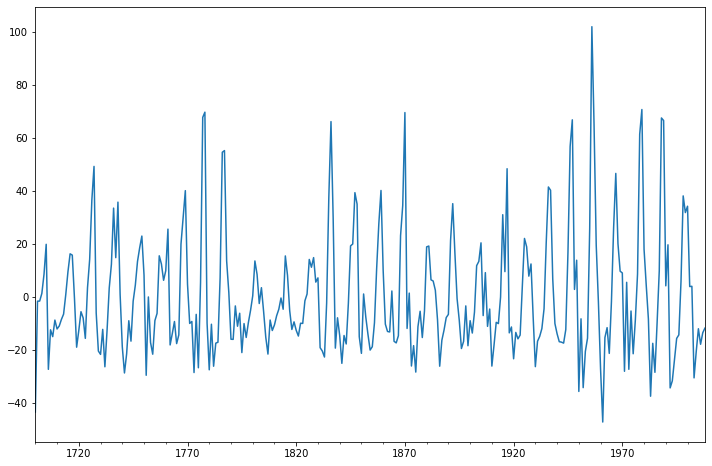

In [ ]:
# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod20.resid.plot(ax=ax);

## Analyzing the Residuals

In the following steps, we calculate the residuals, tests the null hypothesis that the residuals come from a normal distribution, and construct a qq-plot.

In [ ]:
resid20 = arma_mod20.resid
stats.normaltest(resid20)


NormaltestResult(statistic=72.07985764104929, pvalue=2.22873167347614e-16)

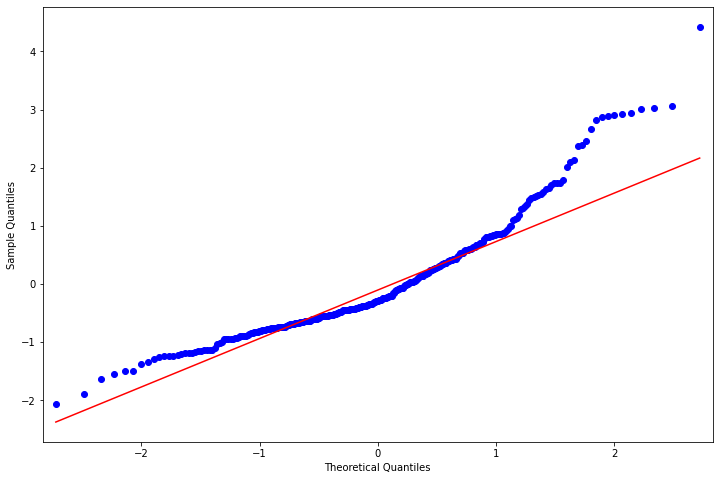

In [ ]:
# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid20, line='q', ax=ax, fit=True)

## Model Autocorrelation

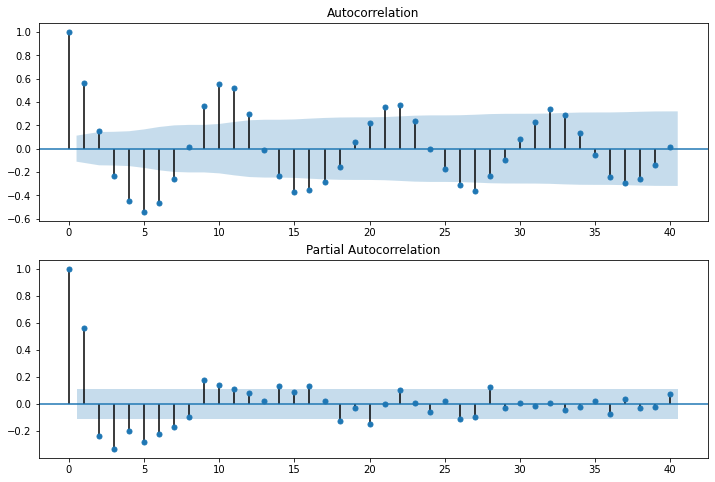

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid20.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid20, lags=40, ax=ax2)

Next, we calculate the lag, autocorrelation (AC), Q statistic and Prob>Q. The Ljung–Box Q test (named for Greta M. Ljung and George E. P. Box) is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero. The null hypothesis is, H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).

In [ ]:
r,q,p = sm.tsa.acf(resid20.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC            Q       Prob(>Q)
lag                                       
1.0   0.561922    98.518912   3.219355e-23
2.0   0.154946   106.034081   9.440431e-24
3.0  -0.236914   123.661079   1.255639e-26
4.0  -0.445261   186.127748   3.599946e-39
5.0  -0.539181   278.027429   5.281275e-58
6.0  -0.462535   345.879830   1.182857e-71
7.0  -0.260944   367.547157   2.153755e-75
8.0   0.015898   367.627855   1.558536e-74
9.0   0.365133   410.334953   8.532342e-83
10.0  0.550091   507.591057  1.053413e-102
11.0  0.523266   595.888386  1.061251e-120
12.0  0.299586   624.928902  5.014388e-126
13.0 -0.009197   624.956365  3.651115e-125
14.0 -0.235965   643.094441  3.532702e-128
15.0 -0.369179   687.644315  7.984283e-137
16.0 -0.351380   728.139610  1.320573e-144
17.0 -0.281668   754.249879  2.522699e-149
18.0 -0.157575   762.449597  3.085234e-150
19.0  0.059681   763.629887  1.144893e-149
20.0  0.223295   780.209655  2.241842e-152
21.0  0.359878   823.424957  9.771525e-161
22.0  0.374

C:\Users\win10\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Notice that the p-values for the Ljung–Box Q test all are well above .05 for lags 1 through 8, indicating “significance.” This is not a desirable result. However, the p-values for the remaining lags through 40 data values as less than .05. So there is much data not contributing to correlations at high lags.


## Predictions

Next, we compute the predictions and analyze their fit against actual values.

In [ ]:
predict_sunspots20 = arma_mod20.predict('1990', '2012', dynamic=True)
print(predict_sunspots20)

1990-12-31    138.427807
1991-12-31    122.621702
1992-12-31    109.590695
1993-12-31     98.847559
1994-12-31     89.990610
1995-12-31     82.688687
1996-12-31     76.668772
1997-12-31     71.705782
1998-12-31     67.614150
1999-12-31     64.240892
2000-12-31     61.459881
2001-12-31     59.167136
2002-12-31     57.276931
2003-12-31     55.718592
2004-12-31     54.433852
2005-12-31     53.374676
2006-12-31     52.501461
2007-12-31     51.781557
2008-12-31     51.188048
2009-12-31     50.698742
2010-12-31     50.295344
2011-12-31     49.962771
2012-12-31     49.688589
Freq: A-DEC, dtype: float64


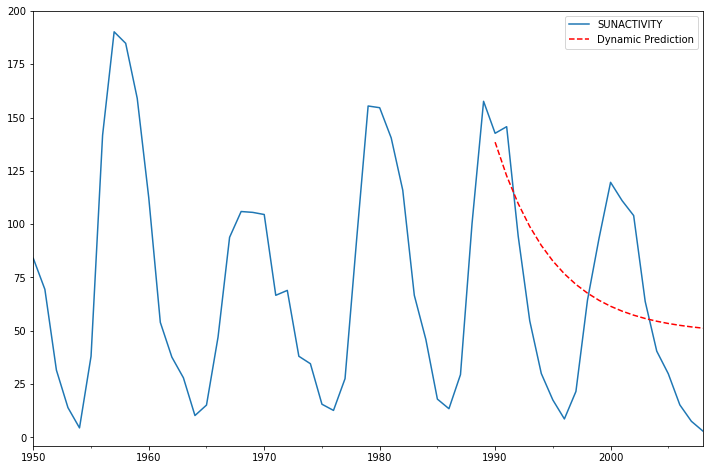

In [ ]:
ax = dta.loc['1950':].plot(figsize=(12,8))
ax = predict_sunspots20.plot(ax=ax, style='r--', label='Dynamic Prediction');
ax.legend();
ax.axis((-20.0, 38.0, -4.0, 200.0));

The fit looks good up to about 1998 and underfit the data afterwards.

## Calculate Forecast Errors

#### Mean absolute error:
The mean absolute error (MAE) value is computed as the average absolute error value. If this value is 0 (zero), the fit (forecast) is perfect. As compared to the mean squared error value, this measure of fit will “de-emphasize” outliers, that is, unique or rare large error values will affect the MAE less than the MSE value.

#### Mean Forecast Error (Bias).
The mean forecast error (MFE) is the average error in the observations. A large positive MFE means that the forecast is undershooting the actual observations, and a large negative MFE means the forecast is overshooting the actual observations. A value near zero is ideal.

The MAE is a better indicator of fit than the MFE.

In [ ]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or percent error = * 100

In [ ]:
print("MFE = ", mean_forecast_err(dta.SUNACTIVITY, predict_sunspots20))
print("MAE = ", mean_absolute_err(dta.SUNACTIVITY, predict_sunspots20))

MFE =  4.730495579457725
MAE =  0.13469289231517673


For MFE > 0, models tends to under-forecast. However, as long as the tracking signal is between –4 and 4, we assume the model is working correctly. The measure of MAE being small would indicate a pretty good fit.